<a href="https://colab.research.google.com/github/NathanSFon/Penguin_category/blob/main/Pinguins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificador de Pinguins
Meu objetivo é fazer um modelo especifico para identificar entre as especies Adelia, Chinstrap penguin(ou pinguim-de-barbicha), Imperador(Emperor penguin) e Geento(Gentoo penguin)


In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

In [ ]:
!pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [ ]:
from duckduckgo_search import DDGS #utilizamos a api da duck para baixar nosso data set e as imagens de validação
from fastcore.all import *

#funcão para retornar a imagem já com nome e tipo correto
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [ ]:
# Primeiro vamos baixar a imagem de um pinguim qualquer, essa imagem será usada para validação do nosso modelo
download_url(search_images('penquin photos', max_images=1)[0], 'penguin.jpg', show_progress=False)

Path('penguin.jpg')

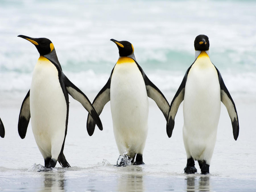

In [ ]:
Image.open('penguin.jpg').to_thumb(256,256)

In [ ]:
# Nesse ponto definimos os topicos de pesquisa e o nome da pasta que serão savos
searches = 'adelie_penguin','Chinstrap_penguin', 'Emperor_penguin', 'Gentoo_penguin'
path = Path('Penquin')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
# Normalmente, durante o download algumas fotos podem ter falhas, famos identificar e removelas
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

31

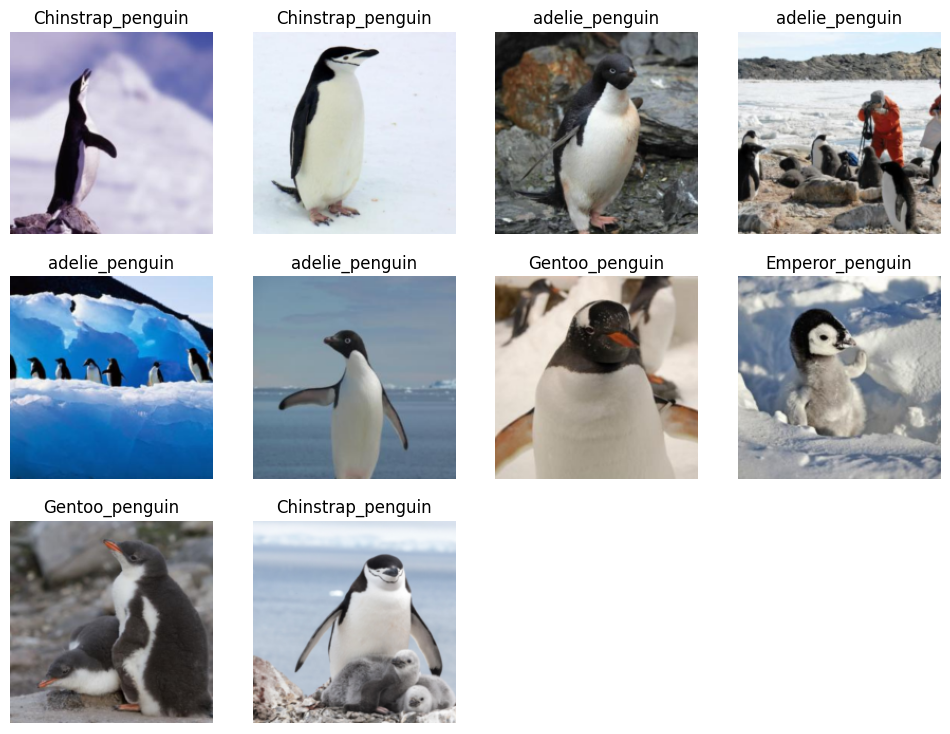

In [32]:
# A biblioteca da fastai facilita muito nosso trabalho, resumindo muitas linhas de codigo
# divisor=RandomSplitter divide os dados em conjuntos de treinamento e validação aleatoriamente, usando 20% dos dados para o conjunto de validação
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='Squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

In [35]:
#Agora podemos fazer o treinamento do modelo, mas uma vez a biblioteca da fastia facilita nosso trabalho,
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4) #deifine com 3 epocas para o modelo

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 45.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.686439,0.598523,0.232394,01:31


epoch,train_loss,valid_loss,error_rate,time
0,0.948248,0.400841,0.169014,02:23
1,0.717331,0.395621,0.147887,02:15
2,0.547130,0.451132,0.140845,02:09
3,0.438055,0.443216,0.161972,02:09


In [36]:
learn.dls.vocab  # Otem a lista de classes do modelo
#famos isso para obter o indice correto para a probabilidade do modelo

['Chinstrap_penguin', 'Emperor_penguin', 'Gentoo_penguin', 'adelie_penguin']

In [39]:
# Carregar a imagem e fazer a previsão
img = PILImage.create('penguin.jpg')
predicted_label, class_idx, probs = learn.predict(img)

# Exibir o resultado
print(f"Predição: {predicted_label}")  # Mostra a classe prevista
print(f"Probabilidade de ser um Penguim Adélia: {probs[3]:.4f}")
print(f"Probabilidade de ser um Penguim Chinstrap: {probs[2]:.4f}")
print(f"Probabilidade de ser um Penguim Imperador: {probs[1]:.4f}")
print(f"Probabilidade de ser um Penguim Geento: {probs[0]:.4f}")

Predição: Emperor_penguin
Probabilidade de ser um Penguim Adélia: 0.0000
Probabilidade de ser um Penguim Chinstrap: 0.0001
Probabilidade de ser um Penguim Imperador: 0.9997
Probabilidade de ser um Penguim Geento: 0.0002


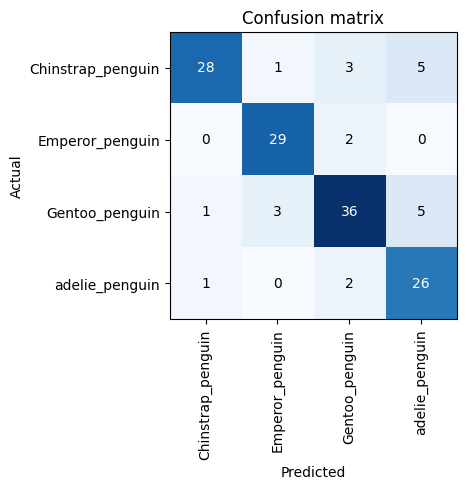

In [38]:
# Interessante - Matris de confusão
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()